<a href="https://colab.research.google.com/github/dbahiense/MachineLearning/blob/main/1_RPi_1_RetrainAnExistingModelA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### What will we make?

We will take an existing model trained to recognise lots of different kinds of images and retrain it to determine whether an image shows dogs or cats. The existing model already knows how to identify interesting features of an image. You will retrain the final layer of the model, which decides what those interesting features make up.

We will also measure how well the model can do this new job, and show how much we’ve improved on the original model in this task.

#### What is a machine learning model anyway?

A model is **a set of rules a computer has learned to complete a task**, such as determining what is in a picture it’s shown.

These **rules are divided up into layers**. Each layer looks at the results of the one before it and tests them against some rules to decide what results to pass to the next layer.

<img scr="https://projects-static.raspberrypi.org/projects/cats-vs-dogs/764c40cd9873202cdfdff4701847ea0a4c8f8841/en/images/neural_network_diagram.png" alt="Neural Network Diagram">


Within each layer there are nodes, which have each learned a rule while the model was being trained, and will test it and produce a result when the model is predicting.

The very first layer is the **input** to the model — an image in this case. The first layer is often called the **input layer** for this reason. The last layer (or **output layer**) of a classifier model like this will always have a number of nodes equal to the number of classifications the model is trained to identify. For example, in the model for this project, there will be two nodes in the final layer, as it will classify its inputs into either pictures of dogs or pictures of cats.

### Prepare a model for retraining

Instead of training a whole new model, for this project we’ll load an existing one, called **MobileNetV2**, and change what it classifies. The MobileNetV2 model is trained to classify lots of different images, which means it is already trained to identify interesting features of an image. So retraining it to use these features to recognise cats or dogs will be much quicker than if you created an ‘Is this a cat or a dog?’ model from scratch.

#### More about MobileNetV2

https://keras.io/api/applications/mobilenet/  
https://paperswithcode.com/method/mobilenetv2

# Let's start coding

### Import the following necessary libraries

*   **`os`** accesses the operating system, to work with the stored image file
*   **`tensorfolow`** does the actual machine learning and image recognition work
*   **`tensorflow_datasets`** gets the data we will use to retrain our model
*   **`numpy`** is used to help convert the image into numbers for the model to read
*   **`maplotlib.pyplot`** displays the image in the Colab notebook

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


### Get the data

This code gets the data we will use to train our model.

This data is a collection of image files and labels for these files, it tells the computer which image is of a cat, and which of a dog.

The data gets broken into three groups, with the percentages defined in the **split** parameter of the load call:

1. **Training data:** Used to train the model — to learn rules and decide how important they are.

2. **Validation data:** Used to evaluate how well the model is performing while it is being trained. It is checked regularly during the training process. It has to be separate to the training data, or the model might learn only the exact images in the training data, with no general rules for identifying a dog or cat.

3. **Testing data:** Not used during the training process, but is used to evaluate how well it performs on unseen data. This check is used to avoid the risk of **overfitting**, where the model learns rules that are specific to the training and validation datasets, but do not apply to all cats and dogs.

In [ ]:
# add this line, as suggested in https://stackoverflow.com/a/72458771, to solve DownloadError
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(raw_training, raw_validation, raw_testing), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

### Batches and Weights

The data in those three groups needs to be broken into **batches** — groups of images. Each batch gets used to train the model before the model’s **weights**, which define how important each rule is, get updated. The bigger the batch, the longer the gap between updates.

There’s no real rule for how big your batches should be, and it may be worth experimenting with different batch sizes on different data, to see if you get better results. Smaller batches can also help you train a model on a computer with less memory (for example, on a Raspberry Pi). Popular sizes are 32, 64, 128, and 256. It is possible to use batches as small as a single image, or as large as your whole dataset. For now, you’ll use 32.

The use of upper case letters here is a convention for variables that are manually set by the programmer (also known as constants or hyperparameters), but not changed in the course of the program. We could just enter 32 directly where the variable gets used, but this makes it easier to update later.

Each batch is chosen randomly from a shuffle buffer of images selected from the full test, validation, or training dataset. You have to define the size of this buffer. The bigger it is, the more randomly shuffled your images will be, which is usually a good thing, but the slower the program will run. Again, start by creating a variable for the buffer size.

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

### Converting the images

The next function takes an image and a label (**metadata**) as inputs. The image is then converted into three sets of numbers representing the colours red, green, and blue for every pixel in the image. The combination of these colours can form any other colour. The red, green, and blue values are then converted from numbers between 0 and 255, to numbers between -1 and 1, as the model has been trained to work with values in that range. Finally, the image is resized based on the **`IMAGE_SIZE`** constant, to match the size the model was previously trained on. In this case, it's a 160 by 160 pixel square.

In [ ]:
IMAGE_SIZE = 160

training_data = None

# Resize an image, and convert it into a form that tensorflow can read more easily 
def prep_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

training_data = raw_training.map(prep_image)
validation_data = raw_validation.map(prep_image)
testing_data = raw_testing.map(prep_image)

### Test the model

The next functions are old friends of us from our previous project. We'll use them for now to test the model and see how it's performing.

In [ ]:
def get_image_from_url(image_url):
  # If the temporary test_image.jpg file already exists, 
  # delete it so a new one can be made.
  if os.path.exists('/root/.keras/datasets/test_image.jpg'):
    os.remove('/root/.keras/datasets/test_image.jpg')

  image_path = tf.keras.utils.get_file('test_image.jpg', origin=image_url)
  return image_path

def print_predictions(predictions):
    for (prediction, number) in zip(predictions[0], range(1, len(predictions[0])+1)):
      print('{}. {} {:.2f}%'.format(number, prediction[1], prediction[2]*100))

def predict_with_old_model(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = original_model.predict(image, batch_size=1)
  predictions = tf.keras.applications.imagenet_utils.decode_predictions(prediction_result, top=15)

  print_predictions(predictions)

def predict_image(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = model.predict(image, batch_size=1)
  labels = metadata.features['label'].names
  print(labels[prediction_result.argmin()])

### Define the shape to the images

The dataset that we’ll use to train the model is made up of 160x160 pixel images and that value is already stored in an **`IMAGE_SIZE`** variable. However, because of how colour works on computers, the images are actually three sets of 160x160 pixels — one each of the red, blue, and green values that combine to form the colour displayed at any given pixel. We'll see more details on this in the next project.

In [ ]:
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

### Import the model

Import the MobileNetV2 model — which is trained to identify loads of different objects — pass it our **`IMAGE_SHAPE`** as its **input_shape** and store it in an **`original_model`** variable.

In [ ]:
original_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE)

14548992/14536120 [==============================] - 0s 0us/step


### Test it

Since MobileNetV2 is designed to run on a mobile device with limited battery, like a phone, it’s not as large or as powerful as some other models. This means it doesn’t always make the best guesses. Before us start changing it, we'll test how good it is by asking it to identify a photo of a ~dog~ wolf as we did in the previous project.

180224/166544 [================================] - 0s 0us/step
1. jigsaw_puzzle 26.75%
2. envelope 8.86%
3. loupe 3.07%
4. strainer 2.91%
5. web_site 2.45%
6. window_screen 2.29%
7. handkerchief 2.16%
8. pinwheel 1.97%
9. umbrella 1.95%
10. syringe 1.63%
11. nail 1.60%
12. pillow 1.51%
13. banded_gecko 1.51%
14. maze 1.26%
15. Chihuahua 0.99%


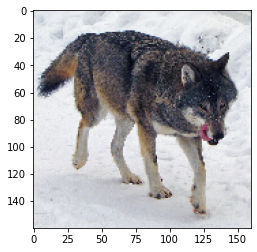

In [ ]:
#predict_with_old_model('https://dojo.soy/predict-dog')
predict_with_old_model('https://upload.wikimedia.org/wikipedia/commons/5/5f/Kolm%C3%A5rden_Wolf.jpg')

Pretty bad, huh?  
That's why we need to retrain the model to improve the predictions.  
We'll do this in the next projetc.  
See you!

# Source

All explanation texts (some slightly modified by [dbahiense](https://github.com/dbahiense/)) are from https://projects.raspberrypi.org/en/projects/cats-vs-dogs/0, except where other sources are given.